# **Classification on Imbalanced Structured Data using Neural Networks**

*Ming Ming Zhang*

In this notebook, the fully connected neural network [TensorFlow implementation](https://) is applied to the [bank marketing dataset](https://http://archive.ics.uci.edu/ml/datasets/bank+marketing). For detailed exploratory data analysis, see the [work](https://drmmz.github.io/). 

Since the data is imbalanced, oversampling and undersampling methods are used on training data. After tuning hyperparameters, the undersampled model (2-layer neural network with 20 hidden units, ReLU activation and adam optimization) has results in AUC $0.957$ and recall $0.940$. 

We also use batch normalization to speed up training and L1-regularization to reveal several key features, e.g., phone call duration, social and economic indicators such as employment rate and contact month of year. At the end, error analysis is provided.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('drive/My Drive/Colab Notebooks/NN/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np

import tensorflow as tf
print('TensorFlow version %s, # GPUs %d' % (tf.__version__, len(tf.config.experimental.list_physical_devices('GPU'))))

import matplotlib.pyplot as plt

import time

import pandas as pd

from nn_tensorflow import FCNet_TF, train

TensorFlow version 2.2.0, # GPUs 0


**1. Load Data**

In [4]:
filename = 'drive/My Drive/Colab Notebooks/NN/bank-additional-full.csv'
raw_df = pd.read_csv(filename, sep=';', header=0)
raw_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
raw_df['id'] = range(len(raw_df))
raw_df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
id                  int64
dtype: object

In [6]:
# Categorical to numerical features
L = []
for x in raw_df.columns:
  if raw_df[x].dtype == 'object':
    L.append(x)
df = pd.get_dummies(raw_df, prefix=L)

df = df.drop(['y_no'], axis=1)
print(df.columns)

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'id',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'mo

In [7]:
neg, pos = np.bincount(df['y_yes'])
total = pos + neg
print('Total examples %d, positives %d, %.2f%% of total' % (total, pos, pos/total*100))

Total examples 41188, positives 4640, 11.27% of total


In [8]:
X = df.drop(['y_yes','id'], axis=1).to_numpy()
y = df['y_yes'].to_numpy()
print('Shapes of total data %s and labels %s' % (X.shape, y.shape)) 

np.random.seed(123)
mask = np.random.permutation(X.shape[0])
X = X[mask]
y = y[mask]

num_training = 39188
num_val = 1000
num_test = 1000
mask_train = list(range(num_training))
X_train = X[mask_train]
y_train = y[mask_train]
mask_val = list(range(num_training, num_training+num_val))
X_val = X[mask_val]
y_val = y[mask_val]
mask_test = list(range(num_training+num_val, num_training+num_val+num_test))
X_test = X[mask_test]
y_test = y[mask_test]

# Normalization
mean_X = np.mean(X_train, axis=0, keepdims=True)
std_X = np.std(X_train, axis=0, keepdims=True)
X_train -= mean_X
X_train /= std_X
X_val -= mean_X
X_val /= std_X
X_test -= mean_X
X_test /= std_X

# Modeling input data
data = {}
data['X_train'] = X_train
data['X_val'] = X_val
data['X_test'] = X_test
data['y_train'] = y_train
data['y_val'] = y_val
data['y_test'] = y_test

print('Shapes of training data %s and labels %s' % (data['X_train'].shape, data['y_train'].shape)) 
print('Shapes of validation data %s and labels %s' % (data['X_val'].shape, data['y_val'].shape))
print('Shapes of test data %s and labels %s' % (data['X_test'].shape, data['y_test'].shape)) 

# pandas dataframe id column added to X_train, X_val and X_test
X_train = np.concatenate((mask[mask_train].reshape(-1,1), X_train), axis=1)
X_val = np.concatenate((mask[mask_val].reshape(-1,1), X_val), axis=1)
X_test = np.concatenate((mask[mask_test].reshape(-1,1), X_test), axis=1)

Shapes of total data (41188, 63) and labels (41188,)
Shapes of training data (39188, 63) and labels (39188,)
Shapes of validation data (1000, 63) and labels (1000,)
Shapes of test data (1000, 63) and labels (1000,)


**2. Baseline Classifier**

In [0]:
# Some setups used in training

D, H1, C = data['X_train'].shape[1], 20, 1
last_activation = 'sigmoid'
loss = 'sigmoid'
metrics = [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 'AUC']
batch_size = 2048
epochs = 50
BatchNorm = True
regularizer = 'L1'
lr = 1e-2
reg = 8e-4

In [0]:
def plot(history):
  plt.subplot(2, 2, 1)
  plt.title('Training loss')
  plt.plot(history.history['loss'], '-o')

  plt.subplot(2, 2, 2)
  plt.title('AUC')
  plt.plot(history.history['auc'], '-o', label='train')
  plt.plot(history.history['val_auc'], '-o', label='val')
  plt.legend(loc='lower right')

  plt.subplot(2, 2, 3)
  plt.title('Precision')
  plt.plot(history.history['precision'], '-o', label='train')
  plt.plot(history.history['val_precision'], '-o', label='val')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')

  plt.subplot(2, 2, 4)
  plt.title('Recall')
  plt.plot(history.history['recall'], '-o', label='train')
  plt.plot(history.history['val_recall'], '-o', label='val')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  
  plt.gcf().set_size_inches(15, 12)
  plt.show()

In [0]:
def evaluate(model, X=data['X_val'], y=data['y_val']):
  results = model.evaluate(X, y, verbose=0)
  for name, value in zip(model.metrics_names, results):
    print('%s: %.3f' % (name, value))
    if name == 'precision':
      p = value
    if name == 'recall':
      r = value
  print('F1-score: %.3f' % (2*p*r/(p+r)))

In [0]:
def imp_features(epsilon, model, df):
  """
  Print out important features based on the threshold epsilon.

  Inputs:
  -epsilon: scalar>0 threshold for the importance
  -model: TensorFlow model
  -df: pandas data frame

  Output:
  -Print out
  """

  weights = model.get_weights()
  W1 = weights[0]

  condition = np.absolute(W1)>epsilon
  idx = np.argwhere(condition) # the indices of important features
  print('Important features:', [df.columns[i] for i in np.unique(idx[:,0])])

In [14]:
t1 = time.time()
base_model = FCNet_TF(input_dim=D, hidden_dims=[H1], num_classes=C, reg=reg, 
                      reg_method=regularizer, bn=BatchNorm, last_activation=last_activation)
base_history = train(base_model, data, loss=loss, lr=lr, batch_size=batch_size, 
                     num_epochs=epochs, metrics=metrics, verbose=0)
t2 = time.time()
print('\nTraining time', t2-t1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Training time 11.74488615989685


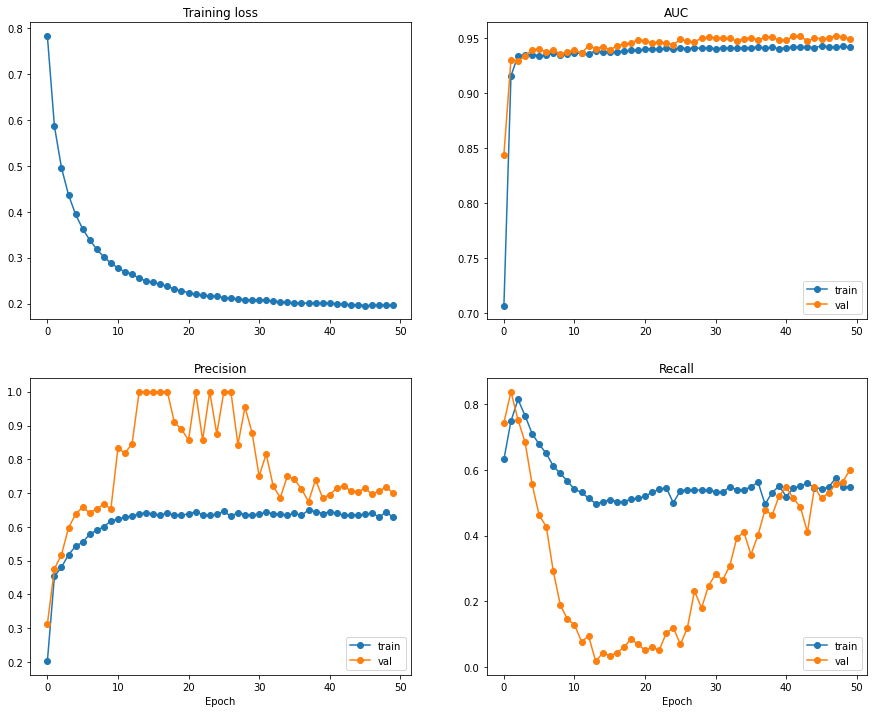

In [15]:
plot(base_history)

In [16]:
evaluate(base_model)

loss: 0.189
precision: 0.700
recall: 0.598
auc: 0.949
F1-score: 0.645


In [17]:
imp_features(epsilon=0.3, model=base_model, df=df)

Important features: ['duration', 'emp.var.rate', 'euribor3m']


**3. Oversampled Classifier**

In [0]:
idx_pos = np.squeeze(np.argwhere(y_train==1)) # indices for training positive labels
idx_neg = np.squeeze(np.argwhere(y_train==0)) # indices for training negative labels
#print(len(idx_pos), len(idx_neg))

np.random.seed(123)
idx_pos_sampled = np.random.choice(idx_pos, size=len(idx_neg)) # oversampled indices

X_train_pos = data['X_train'][idx_pos_sampled] # positive training data
y_train_pos = y_train[idx_pos_sampled] # positive training labels
X_train_neg = data['X_train'][idx_neg] # negative training data
y_train_neg = y_train[idx_neg] # negative training labels

X_train_sampled = np.concatenate([X_train_pos, X_train_neg], axis=0) # oversampled training data
y_train_sampled = np.concatenate([y_train_pos, y_train_neg], axis=0) # oversampled training labels 

mask_sampled = np.random.permutation(X_train_sampled.shape[0])
X_train_sampled = X_train_sampled[mask_sampled]
y_train_sampled = y_train_sampled[mask_sampled]

data_oversampled = data.copy()
data_oversampled['X_train'] = X_train_sampled
data_oversampled['y_train'] = y_train_sampled

print('Shapes of oversampled training data %s and labels %s' % (data_oversampled['X_train'].shape, data_oversampled['y_train'].shape))
print('Sanity check:', data_oversampled['y_train'][:5], np.bincount(data_oversampled['y_train']))

Shapes of oversampled training data (69562, 63) and labels (69562,)
Sanity check: [1 0 1 0 1] [34781 34781]


In [0]:
t1 = time.time()
oversampled_model = FCNet_TF(input_dim=D, hidden_dims=[H1], num_classes=C, reg=reg, 
                      reg_method=regularizer, bn=BatchNorm, last_activation=last_activation)
oversampled_history = train(oversampled_model, data_oversampled, loss=loss, lr=lr, 
                            batch_size=batch_size, num_epochs=epochs, metrics=metrics, verbose=0)
t2 = time.time()

print('\nTraining time', t2-t1)


Training time 17.09265637397766


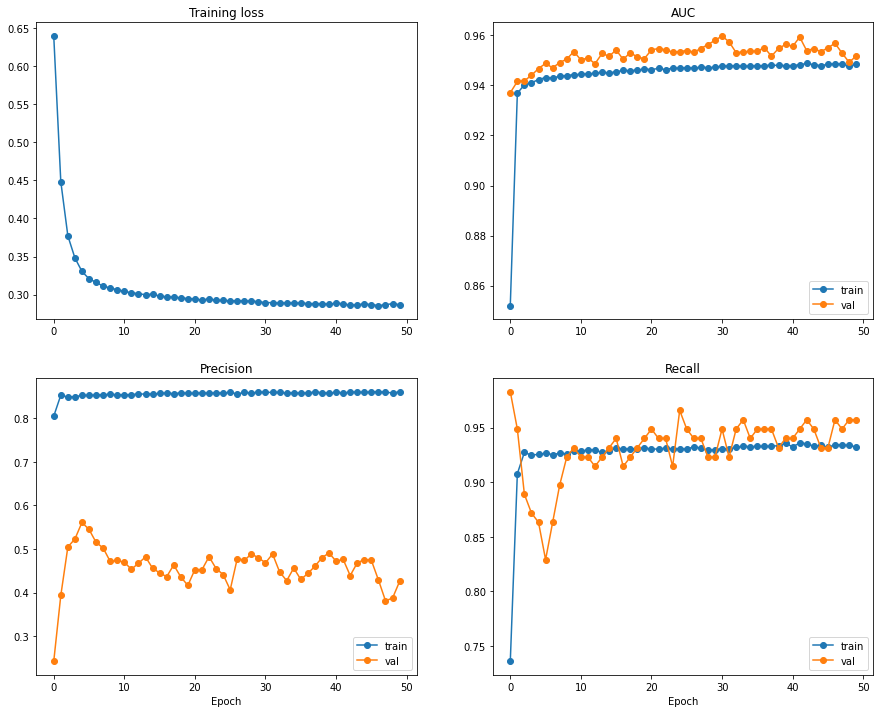

In [0]:
plot(oversampled_history)

In [0]:
evaluate(oversampled_model)

loss: 0.361
precision: 0.426
recall: 0.957
auc: 0.952
F1-score: 0.589


In [0]:
imp_features(epsilon=0.3, model=oversampled_model, df=df)

Important features: ['duration', 'emp.var.rate', 'euribor3m', 'month_mar']


**4. Undersampled Classifer**

In [0]:
idx_pos = np.squeeze(np.argwhere(y_train==1)) # indices for training positive labels
idx_neg = np.squeeze(np.argwhere(y_train==0)) # indices for training negative labels
#print(len(idx_pos), len(idx_neg))

np.random.seed(123)
idx_neg_sampled = np.random.choice(idx_neg, size=len(idx_pos), replace=False) # undersampled indices

X_train_pos = data['X_train'][idx_pos] # positive training data
y_train_pos = y_train[idx_pos] # positive training labels
X_train_neg = data['X_train'][idx_neg_sampled] # negative training data
y_train_neg = y_train[idx_neg_sampled] # negative training labels

X_train_sampled = np.concatenate([X_train_pos, X_train_neg], axis=0) # undersampled training data
y_train_sampled = np.concatenate([y_train_pos, y_train_neg], axis=0) # undersampled training labels 

mask_sampled = np.random.permutation(X_train_sampled.shape[0])
X_train_sampled = X_train_sampled[mask_sampled]
y_train_sampled = y_train_sampled[mask_sampled]

data_undersampled = data.copy()
data_undersampled['X_train'] = X_train_sampled
data_undersampled['y_train'] = y_train_sampled

print('Shapes of undersampled training data %s and labels %s' % (data_undersampled['X_train'].shape, data_undersampled['y_train'].shape))
print('Sanity check:', data_undersampled['y_train'][:5], np.bincount(data_undersampled['y_train']))

Shapes of undersampled training data (8814, 63) and labels (8814,)
Sanity check: [0 0 1 1 0] [4407 4407]


In [0]:
t1 = time.time()
undersampled_model = FCNet_TF(input_dim=D, hidden_dims=[H1], num_classes=C, reg=reg, 
                      reg_method=regularizer, bn=BatchNorm, last_activation=last_activation)
undersampled_history = train(undersampled_model, data_undersampled, loss=loss, lr=lr, 
                            batch_size=516, num_epochs=epochs, metrics=metrics, verbose=0)
t2 = time.time()

print('\nTraining time', t2-t1)


Training time 6.065906524658203


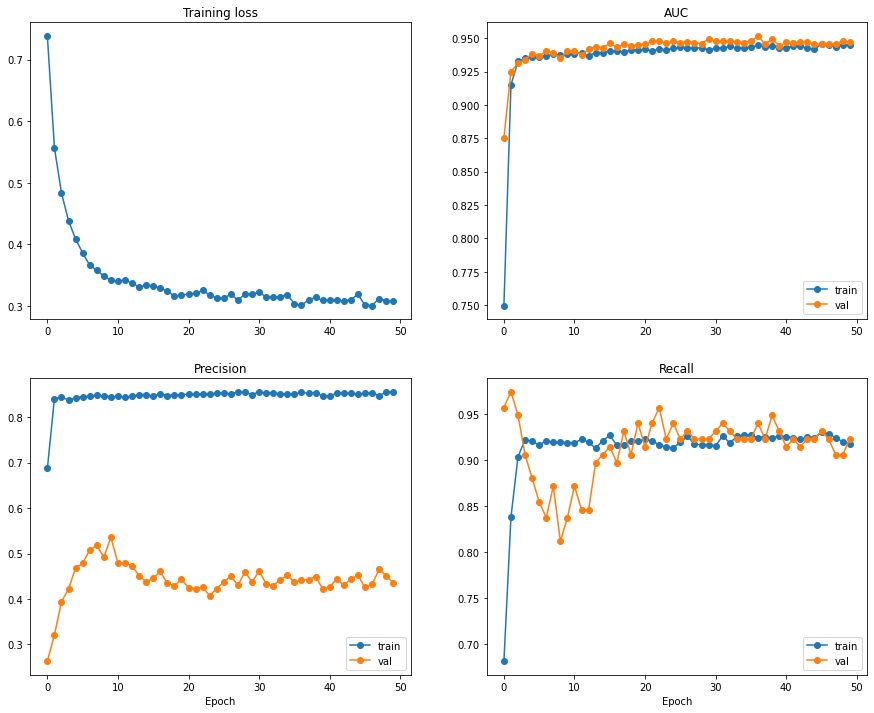

In [0]:
plot(undersampled_history)

In [0]:
evaluate(undersampled_model)

loss: 0.329
precision: 0.435
recall: 0.923
auc: 0.947
F1-score: 0.592


In [0]:
imp_features(epsilon=0.3, model=undersampled_model, df=df)

Important features: ['duration', 'emp.var.rate', 'nr.employed', 'loan_yes', 'contact_cellular', 'month_mar', 'month_nov']


**5. Tuning Hyperparameters**

5.1 Undersampled Tuning

In [0]:
thisData = data_undersampled
batch_size = 516
epochs = 50

results = {}
best_val = -1

max_count = 30
for count in range(max_count):
  lr = 10 ** np.random.uniform(-3, -1)
  reg = 10 ** np.random.uniform(-5, -3)

  print('Training lr %e reg %e' % (lr, reg))
  model = FCNet_TF(input_dim=D, hidden_dims=[H1], num_classes=C, bn=BatchNorm,
                   reg=reg, reg_method=regularizer, last_activation=last_activation)
  history = train(model, thisData, loss=loss, lr=lr, batch_size=batch_size,
                  num_epochs=epochs, metrics=metrics, verbose=0)
  
  results_train = model.evaluate(thisData['X_train'], thisData['y_train'], verbose=0)
  results_val = model.evaluate(thisData['X_val'], thisData['y_val'], verbose=0)
  train_recall = results_train[2]
  train_auc = results_train[3]
  val_recall = results_val[2]
  val_auc = results_val[3]
  print('val_auc %.3f, val_recall %.3f\n' %(val_auc, val_recall))
  results[(lr, reg)] = (train_recall, val_recall, val_auc)
  if val_recall > best_val:
    best_val = val_recall

for lr, reg in sorted(results):
    train_recall, val_recall, val_auc = results[(lr, reg)]
    print('lr %e reg %e, train recall: %.3f val recall: %.3f val_auc: %.3f' % (lr, reg, train_recall, val_recall, val_auc))
    
print('best validation recall achieved during cross-validation: %.3f' % best_val)

Training lr 1.556943e-03 reg 4.856657e-04
val_auc 0.947, val_recall 0.932

Training lr 2.588241e-02 reg 2.480573e-05
val_auc 0.933, val_recall 0.880

Training lr 4.553778e-02 reg 8.119022e-05
val_auc 0.944, val_recall 0.906

Training lr 8.809846e-03 reg 6.499130e-04
val_auc 0.945, val_recall 0.940

Training lr 2.702632e-02 reg 1.933079e-05
val_auc 0.944, val_recall 0.906

Training lr 1.956338e-02 reg 8.773230e-04
val_auc 0.942, val_recall 0.932

Training lr 8.837232e-03 reg 6.524887e-04
val_auc 0.946, val_recall 0.897

Training lr 9.536629e-03 reg 8.494015e-05
val_auc 0.937, val_recall 0.897

Training lr 1.231163e-02 reg 1.681577e-05
val_auc 0.935, val_recall 0.880

Training lr 2.297222e-03 reg 3.519045e-04
val_auc 0.943, val_recall 0.915

Training lr 1.769570e-03 reg 1.176270e-04
val_auc 0.944, val_recall 0.932

Training lr 3.193889e-03 reg 5.942308e-04
val_auc 0.952, val_recall 0.949

Training lr 2.331638e-03 reg 9.046712e-04
val_auc 0.948, val_recall 0.957

Training lr 2.602232e-02 

In [0]:
lr = 2.3e-3
reg = 9e-4
epochs = 100

t1 = time.time()
undersampled_final_model = FCNet_TF(input_dim=D, hidden_dims=[H1], num_classes=C, reg=reg, 
                      reg_method=regularizer, bn=BatchNorm, last_activation=last_activation)
undersampled_final_history = train(undersampled_final_model, thisData, loss=loss, lr=lr, 
                            batch_size=batch_size, num_epochs=epochs, metrics=metrics, verbose=0)
t2 = time.time()

print('\nTraining time', t2-t1)


Training time 32.01989483833313


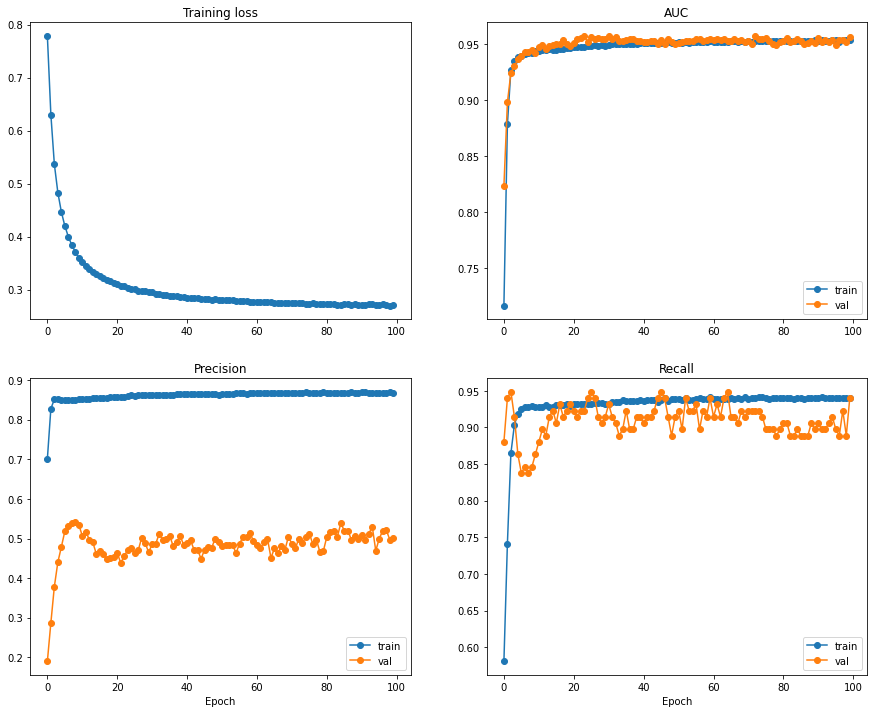

In [0]:
plot(undersampled_final_history)

In [0]:
evaluate(undersampled_final_model)

loss: 0.280
precision: 0.502
recall: 0.940
auc: 0.957
F1-score: 0.655


In [0]:
imp_features(epsilon=0.2, model=undersampled_final_model, df=df)

Important features: ['duration', 'emp.var.rate', 'euribor3m']


5.2 Oversampled Tuning

In [0]:
thisData = data_oversampled
batch_size = 2048
epochs = 50

results = {}
best_val = -1

max_count = 30
for count in range(max_count):
  lr = 10 ** np.random.uniform(-3, -1)
  reg = 10 ** np.random.uniform(-5, -3)

  print('Training lr %e reg %e' % (lr, reg))
  model = FCNet_TF(input_dim=D, hidden_dims=[H1], num_classes=C, bn=BatchNorm,
                   reg=reg, reg_method=regularizer, last_activation=last_activation)
  history = train(model, thisData, loss=loss, lr=lr, batch_size=batch_size,
                  num_epochs=epochs, metrics=metrics, verbose=0)
  
  results_train = model.evaluate(thisData['X_train'], thisData['y_train'], verbose=0)
  results_val = model.evaluate(thisData['X_val'], thisData['y_val'], verbose=0)
  train_recall = results_train[2]
  train_auc = results_train[3]
  val_recall = results_val[2]
  val_auc = results_val[3]
  print('val_auc %.3f, val_recall %.3f\n' %(val_auc, val_recall))
  results[(lr, reg)] = (train_recall, val_recall, val_auc)
  if val_recall > best_val:
    best_val = val_recall

for lr, reg in sorted(results):
    train_recall, val_recall, val_auc = results[(lr, reg)]
    print('lr %e reg %e, train recall: %.3f val recall: %.3f val_auc: %.3f' % (lr, reg, train_recall, val_recall, val_auc))
    
print('best validation recall achieved during cross-validation: %.3f' % best_val)

Training lr 5.057499e-02 reg 1.050408e-04
val_auc 0.949, val_recall 0.897

Training lr 2.805677e-02 reg 1.058966e-05
val_auc 0.943, val_recall 0.897

Training lr 2.056270e-02 reg 4.799879e-04
val_auc 0.954, val_recall 0.897

Training lr 5.354715e-03 reg 6.835518e-04
val_auc 0.953, val_recall 0.915

Training lr 2.210009e-03 reg 8.569786e-04
val_auc 0.957, val_recall 0.915

Training lr 3.441653e-02 reg 4.769828e-05
val_auc 0.948, val_recall 0.880

Training lr 1.128090e-02 reg 1.177315e-05
val_auc 0.947, val_recall 0.880

Training lr 2.408459e-02 reg 1.693972e-04
val_auc 0.951, val_recall 0.932

Training lr 1.211631e-03 reg 1.679097e-04
val_auc 0.955, val_recall 0.906

Training lr 2.772318e-02 reg 1.135838e-05
val_auc 0.950, val_recall 0.915

Training lr 5.491736e-02 reg 1.428966e-05
val_auc 0.946, val_recall 0.915

Training lr 3.724855e-03 reg 6.602883e-04
val_auc 0.959, val_recall 0.906

Training lr 1.097777e-03 reg 5.801742e-05
val_auc 0.954, val_recall 0.915

Training lr 7.773575e-03 

In [0]:
lr = 7.7e-3
reg = 9e-4
epochs = 100

t1 = time.time()
oversampled_final_model = FCNet_TF(input_dim=D, hidden_dims=[H1], num_classes=C, reg=reg, 
                      reg_method=regularizer, bn=BatchNorm, last_activation=last_activation)
oversampled_final_history = train(oversampled_final_model, thisData, loss=loss, lr=lr, 
                            batch_size=batch_size, num_epochs=epochs, metrics=metrics, verbose=0)
t2 = time.time()
print('\nTraining time', t2-t1)


Training time 32.59374952316284


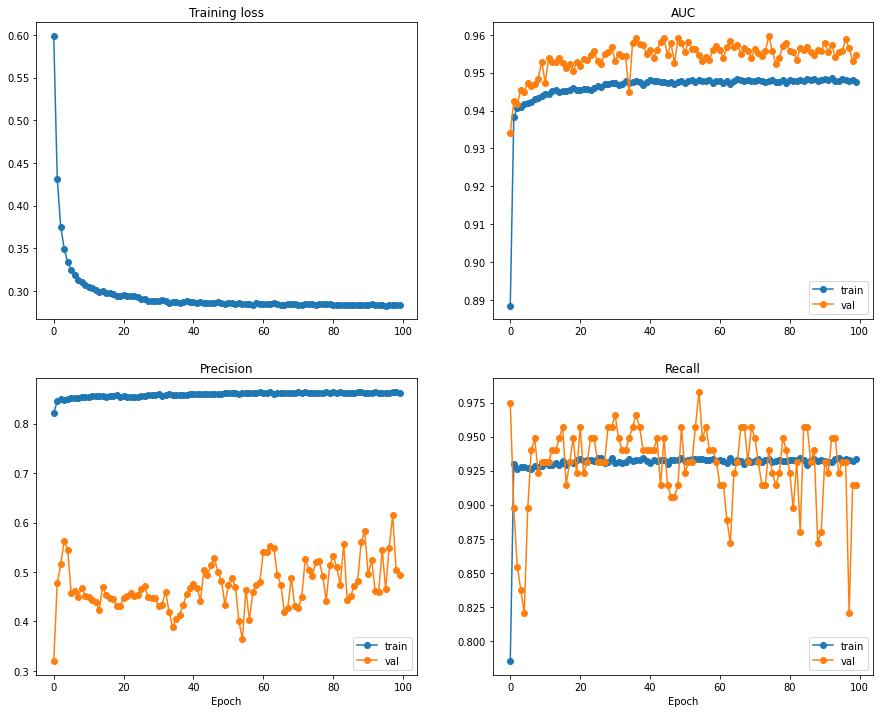

In [0]:
plot(oversampled_final_history)

In [0]:
evaluate(oversampled_final_model)

loss: 0.283
precision: 0.493
recall: 0.915
auc: 0.955
F1-score: 0.641


In [0]:
imp_features(epsilon=0.3, model=oversampled_final_model, df=df)

Important features: ['duration', 'emp.var.rate', 'nr.employed', 'month_mar', 'month_may']


**6. Error Analysis**

In [0]:
evaluate(undersampled_final_model)

loss: 0.280
precision: 0.502
recall: 0.940
auc: 0.957
F1-score: 0.655


In [0]:
y_hat = undersampled_final_model.predict(data_undersampled['X_test']).reshape(-1)
y_hat[y_hat>0.5] = 1
y_hat[y_hat<=0.5] = 0
tf.math.confusion_matrix(labels=data_undersampled['y_test'], predictions=y_hat).numpy()

array([[771, 113],
       [  7, 109]], dtype=int32)

In [0]:
mismatches = np.argwhere((data_undersampled['y_test']==1) & (y_hat==0)).reshape(-1)
print('Wrong predictions (row in the test set): %s' % mismatches)

Wrong predictions (row in the test set): [ 47 194 332 399 426 484 577]


In [0]:
mismatches_id = X_test[mismatches,0]
print(mismatches_id)
mismatches_df = df.iloc[mismatches_id]
mismatches_df

[36749. 38440. 16656. 12264.  4851. 24087. 28132.]


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,id,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes
36749,43,131,4,999,1,-2.9,92.963,-40.8,1.281,5076.2,36749,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1
38440,24,97,1,999,0,-3.4,92.431,-26.9,0.733,5017.5,38440,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1
16656,51,228,2,999,0,1.4,93.918,-42.7,4.963,5228.1,16656,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
12264,34,676,1,999,0,1.4,93.918,-42.7,4.966,5228.1,12264,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
4851,46,506,2,999,0,1.1,93.994,-36.4,4.858,5191.0,4851,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1
24087,31,115,1,999,0,-0.1,93.200,-42.0,4.474,5195.8,24087,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1
28132,53,583,2,999,1,-1.8,93.075,-47.1,1.466,5099.1,28132,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1


In [0]:
mismatches_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,id,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes
count,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.0,7.0,7.0,7.000000,7.0,7.000000,7.000000,7.0,7.000000,7.0,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.000000,7.0,7.0,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.0,7.0
mean,40.285714,333.714286,1.857143,999.0,0.285714,-0.614286,93.357000,-39.800000,3.248714,5147.971429,23025.571429,0.428571,0.428571,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.714286,0.142857,0.0,0.285714,0.142857,0.285714,0.0,0.0,0.0,0.285714,0.0,0.714286,0.285714,0.0,0.285714,0.0,0.714286,0.857143,0.0,0.142857,0.428571,0.571429,0.142857,0.0,0.0,0.285714,0.142857,0.0,0.142857,0.142857,0.142857,0.0,0.142857,0.285714,0.285714,0.0,0.285714,0.285714,0.714286,0.0,1.0
std,10.858396,246.685842,1.069045,0.0,0.487950,2.069967,0.598901,6.505382,1.973059,83.209128,12515.571965,0.534522,0.534522,0.0,0.377964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.377964,0.487950,0.377964,0.0,0.487950,0.377964,0.487950,0.0,0.0,0.0,0.487950,0.0,0.487950,0.487950,0.0,0.487950,0.0,0.487950,0.377964,0.0,0.377964,0.534522,0.534522,0.377964,0.0,0.0,0.487950,0.377964,0.0,0.377964,0.377964,0.377964,0.0,0.377964,0.487950,0.487950,0.0,0.487950,0.487950,0.487950,0.0,0.0
min,24.000000,97.000000,1.000000,999.0,0.000000,-3.400000,92.431000,-47.100000,0.733000,5017.500000,4851.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0
25%,32.500000,123.000000,1.000000,999.0,0.000000,-2.350000,93.019000,-42.700000,1.373500,5087.650000,14460.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.500000,0.000000,0.0,0.000000,0.0,0.500000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.0,1.0
50%,43.000000,228.000000,2.000000,999.0,0.000000,-0.100000,93.200000,-42.000000,4.474000,5191.000000,24087.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.0,1.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,1.0
75%,48.500000,544.500000,2.000000,999.0,0.500000,1.250000,93.918000,-38.600000,4.910500,5211.950000,32440.500000,1.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.500000,0.000000,0.500000,0.0,0.0,0.

In [0]:
df[df['y_yes']==1].describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,id,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes
count,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.0,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.000000,4640.0
mean,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991,30361.742888,0.291379,0.137500,0.026724,0.022845,0.070690,0.093534,0.032112,0.069612,0.059267,0.157328,0.031034,0.007974,0.102586,0.545690,0.349138,0.002586,0.092241,0.040517,0.101940,0.222198,0.000862,0.128233,0.359914,0.054095,0.904526,0.095474,0.0,0.436638,0.023060,0.540302,0.829741,0.023060,0.147198,0.830388,0.169612,0.116164,0.141164,0.019181,0.139871,0.120474,0.059483,0.190948,0.089655,0.067888,0.055172,0.182328,0.182543,0.225216,0.205388,0.204526,0.130388,0.676940,0.192672,1.0
std,13.837476,401.171871,1.666245,403.407181,0.860344,1.623626,0.676644,6.139668,1.742598,87.572641,10784.272734,0.454447,0.344412,0.161293,0.149425,0.256333,0.291211,0.176317,0.254520,0.236150,0.364149,0.173430,0.088951,0.303450,0.497962,0.476749,0.050794,0.289398,0.197190,0.302602,0.415769,0.029352,0.334385,0.480027,0.226229,0.293900,0.293900,0.0,0.496022,0.150111,0.498427,0.375900,0.150111,0.354342,0.375332,0.375332,0.320456,0.348228,0.137176,0.346890,0.325550,0.236552,0.393091,0.285718,0.251581,0.228341,0.386156,0.386333,0.417769,0.404028,0.403398,0.336766,0.467696,0.394440,0.0
min,17.000000,37.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,31.000000,253.000000,1.000000,999.000000,0.000000,-1.800000,92.893000,-46.200000,0.849000,5017.500000,24095.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

Note that the values of `contact_cellular` and `duration` have high differences between model predictions ($\widehat{y}=0$) and actual labels ($y=1$). 